# Week 5: Kaggle Mini-Project - "I'm Something of a Painter Myself

### By Julian Moscotte

## Introduction

The challenge of this project involces creating a Generative Adversarial Network (GAN) to generate images in the style of Claude Monet. The GAN will consist of 2 neural networks: a generator and descriminator. The generators task will be to create images in the style of Money, while the descriminator's role is to distinguish between real Money paintings and those generated by the mdoel. These will be trained together in an adversarial process, where the generator is trying to fool the discriminator. We will be creating 7000-10,000 images. 

### Data Overview

The dataset we're working with is as follows:

- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

We will be using the jpg files in this case (the main difference between tfrec and JPG is just file type). The Monet_jpg folder contains monet paintings to train on, while the photo directories contain photos that we will transform to be in Monet Style. From the bullets above we see the size of the datasets as well as the dimensions of the images. Lets take a deeper look into the dataset. 

Here we can visually confirm that these are Monet paintings, while I'm not super familiar with identifying Monet paintings, I trust the source given that these are actually by Claude himself. Lets make sure that this dataset is good to go, so we'll perform some data cleaning checks. 

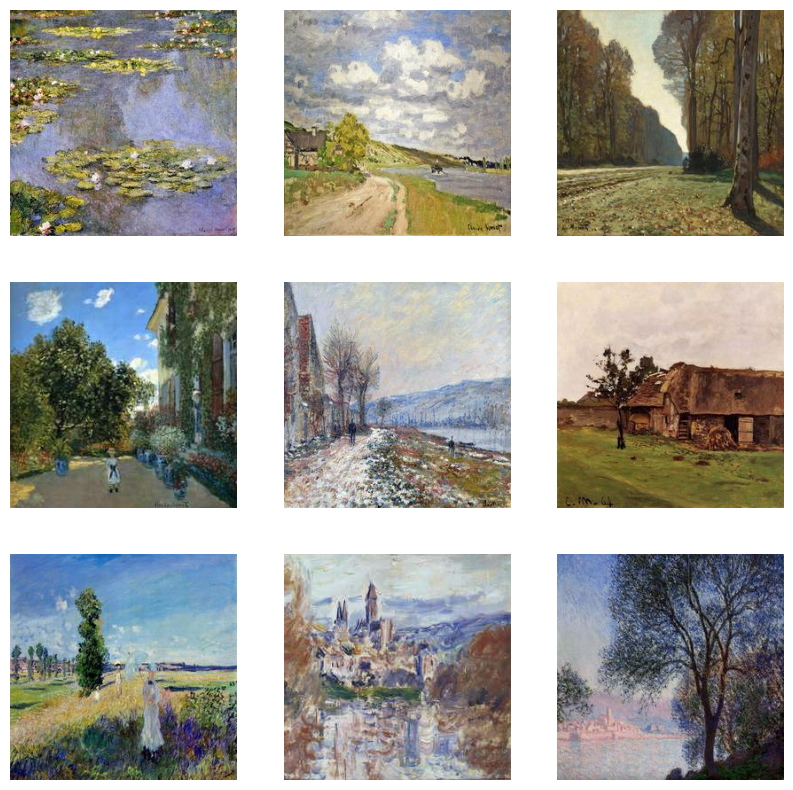

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directory containing Monet-style images
image_dir = '/kaggle/input/gan-getting-started/monet_jpg'

# Load and display a few sample images
sample_images = os.listdir(image_dir)[:9]  # Adjust the number of images to display
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    img = Image.open(os.path.join(image_dir, sample_images[i]))
    ax.imshow(np.array(img))
    ax.axis('off')

plt.show()

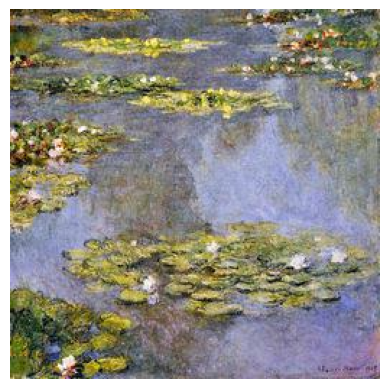

In [2]:
from torchvision import transforms

# Define a transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Apply transformation to a sample image
img = Image.open(os.path.join(image_dir, sample_images[0]))
transformed_img = transform(img)

# Display transformed image
plt.imshow(transformed_img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.axis('off')
plt.show()

What we've done here is normalized the image and create torchvision tensors for our data processing. This is quite a nice photo, lets try to trick a computer into thinking we made something like this.

### Plan  of Analysis

Now that our data is in a good place we're going to look to our Model development. We'll create the GAN model with a basic architecture of the generator and descriminator. Next we'll train the images while monitoring the performance of both parts of the model and do some hyperparameter tuning as necessary to improve the generated images. Once this is done we'll transform the 7000 images in the photo_jpg folder into Monet-like paintings. 

## Model Architecture

For this project I'll be using a CycleGAN structure. This is well suited for image transformation because it does not need a one-for-one pair for the photos-to Monet paintings. 

We will create the Generators (G and F):

- Input: Image from one domain (photo)
- Layers:
 - Convolutional layer with padding and ReLU
 - Downsampling with convolutional layers
 - Several residual blocks for adding complexity
 - upsampling with transpose convolutions
 - Final convolutional layer with Tanh activation
- Output

Next we will create the Descriminators as such (D_X and D_Y):

- Input: Image patch
- Layers:
 - Several convolutional layers with LeakyReLU activation
 - Final convolutional layer to output a probability
- Output: Patch level probability of the image being real

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Generator and Discriminator models
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 7, stride=1, padding=3),
            nn.Tanh()  # Outputs images in range [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # Output: 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # Output: 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # Output: 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 3, stride=1, padding=1)    # Output: 32x32
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through the discriminator
        x = self.model(x)
        # Upsample the output to match the input dimensions
        x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return self.sigmoid(x)

In [4]:
def cycle_loss(real_image, reconstructed_image, lambda_cycle=10.0):
    return lambda_cycle * nn.functional.l1_loss(reconstructed_image, real_image)

def identity_loss(real_image, same_image, lambda_identity=5.0):
    return lambda_identity * nn.functional.l1_loss(same_image, real_image)


In [5]:
import torch.optim as optim

# Instantiate models
G_XtoY = Generator()
G_YtoX = Generator()
D_X = Discriminator()
D_Y = Discriminator()

# Define loss functions
criterion_gan = nn.BCELoss()
criterion_cycle = cycle_loss
criterion_identity = identity_loss

# Define optimizers
optimizer_G = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

G_XtoY.to(device)
G_YtoX.to(device)
D_X.to(device)
D_Y.to(device)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (sigmoid): Sigmoid()
)

Above we've created our Generators and Descriminators now lets take a look at training this data.

In [6]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

def load_data(photo_path, monet_path, batch_size):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # List all image files in both folders
    photo_images = [os.path.join(photo_path, fname) for fname in os.listdir(photo_path) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
    monet_images = [os.path.join(monet_path, fname) for fname in os.listdir(monet_path) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Create dataset and dataloader for both
    dataset_X = CustomDataset(paths=photo_images, transform=transform)
    dataset_Y = CustomDataset(paths=monet_images, transform=transform)
    
    dataloader_X = DataLoader(dataset_X, batch_size=batch_size, shuffle=True, drop_last=True)
    dataloader_Y = DataLoader(dataset_Y, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return dataloader_X, dataloader_Y

def resize_image(image, size):
    # Check if the image is a batch of images
    if image.ndimension() == 4:  # Batch of images (N, C, H, W)
        return F.interpolate(image, size=size, mode='bilinear', align_corners=False)
    elif image.ndimension() == 3:  # Single image (C, H, W)
        return F.interpolate(image.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)
    else:
        raise ValueError(f"Unsupported tensor dimension: {image.ndimension()}")


# Paths to the folders
photo_path = '/kaggle/input/gan-getting-started/photo_jpg'
monet_path = '/kaggle/input/gan-getting-started/monet_jpg'

dataloader_X, dataloader_Y = load_data(photo_path, monet_path, batch_size=14)

In [ ]:


# Training loop
num_epochs = 10
target_size = (256, 256)  # Set target size for consistency

for epoch in range(num_epochs):
    dataloader_Y_iter = iter(dataloader_Y)  # Create an iterator for dataloader_Y
    for i, real_X in enumerate(dataloader_X):
        real_X = real_X.to(device)
        
        try:
            real_Y = next(dataloader_Y_iter).to(device)
        except StopIteration:
            # Recreate the iterator if exhausted
            dataloader_Y_iter = iter(dataloader_Y)
            real_Y = next(dataloader_Y_iter).to(device)
        
        # Resize images to match target size
        real_X_resized = resize_image(real_X, target_size).to(device)
        real_Y_resized = resize_image(real_Y, target_size).to(device)
        
        # Create labels with the same size as the images
        valid = torch.ones(real_X_resized.size(0), 1, target_size[0], target_size[1]).to(device)
        fake = torch.zeros(real_X_resized.size(0), 1, target_size[0], target_size[1]).to(device)
        
        # -----------------
        #  Train Generators
        # -----------------
        optimizer_G.zero_grad()
        
        # GAN loss
        fake_Y = G_XtoY(real_X_resized)
        fake_Y_resized = resize_image(fake_Y, target_size)
        loss_G_Y = criterion_gan(D_Y(fake_Y_resized), valid)
        
        fake_X = G_YtoX(real_Y_resized)
        fake_X_resized = resize_image(fake_X, target_size)
        loss_G_X = criterion_gan(D_X(fake_X_resized), valid)
        
        # Cycle loss
        reconstructed_X = G_YtoX(fake_Y_resized)
        loss_cycle_X = criterion_cycle(real_X_resized, reconstructed_X)
        
        reconstructed_Y = G_XtoY(fake_X_resized)
        loss_cycle_Y = criterion_cycle(real_Y_resized, reconstructed_Y)
        
        # Identity loss
        same_X = G_YtoX(real_X_resized)
        loss_identity_X = criterion_identity(real_X_resized, same_X)
        
        same_Y = G_XtoY(real_Y_resized)
        loss_identity_Y = criterion_identity(real_Y_resized, same_Y)
        
        # Total loss
        loss_G = loss_G_Y + loss_G_X + loss_cycle_X + loss_cycle_Y + loss_identity_X + loss_identity_Y
        loss_G.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminators
        # ---------------------
        optimizer_D_X.zero_grad()
        
        # Discriminator X
        loss_D_X_real = criterion_gan(D_X(real_X_resized), valid)
        loss_D_X_fake = criterion_gan(D_X(fake_X_resized.detach()), fake)
        loss_D_X = (loss_D_X_real + loss_D_X_fake) / 2
        
        loss_D_X.backward()
        optimizer_D_X.step()
        
        optimizer_D_Y.zero_grad()
        
        # Discriminator Y
        loss_D_Y_real = criterion_gan(D_Y(real_Y_resized), valid)
        loss_D_Y_fake = criterion_gan(D_Y(fake_Y_resized.detach()), fake)
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) / 2
        
        loss_D_Y.backward()
        optimizer_D_Y.step()
        
        print(f'Epoch [{epoch}/{num_epochs}]  Loss D_X: {loss_D_X.item()}  Loss D_Y: {loss_D_Y.item()}  Loss G: {loss_G.item()}')

This model took around 2 hours to train so we'll some hyper parameter tuning on a much smaller sample size. Then use the best one from there on our entire set.

In [15]:
import os
import random
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

def resize_image(image, size):
    # Check if the image is a batch of images
    if image.ndimension() == 4:  # Batch of images (N, C, H, W)
        return F.interpolate(image, size=size, mode='bilinear', align_corners=False)
    elif image.ndimension() == 3:  # Single image (C, H, W)
        return F.interpolate(image.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)
    else:
        raise ValueError(f"Unsupported tensor dimension: {image.ndimension()}")

def load_data(photo_path, monet_path, batch_size, sample_size):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # List all image files in both folders
    photo_images = [os.path.join(photo_path, fname) for fname in os.listdir(photo_path) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
    monet_images = [os.path.join(monet_path, fname) for fname in os.listdir(monet_path) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Select a random sample of the dataset
    photo_images = random.sample(photo_images, sample_size)
    monet_images = random.sample(monet_images, sample_size)
    
    # Create dataset and dataloader for both
    dataset_X = CustomDataset(paths=photo_images, transform=transform)
    dataset_Y = CustomDataset(paths=monet_images, transform=transform)
    
    dataloader_X = DataLoader(dataset_X, batch_size=batch_size, shuffle=True, drop_last=True)
    dataloader_Y = DataLoader(dataset_Y, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return dataloader_X, dataloader_Y

def hyperparameter_tuning(photo_path, monet_path, batch_size, sample_size, learning_rate_options, lambda_cycle_options):
    results = []  # To store results for each hyperparameter combination

    # Prepare the data
    dataloader_X, dataloader_Y = load_data(photo_path, monet_path, batch_size, sample_size)
    
    # Hyperparameter tuning
    for lr in learning_rate_options:
        for lambda_cycle in lambda_cycle_options:
            print(f'Tuning with learning rate: {lr} and lambda_cycle: {lambda_cycle}')
            
            # Initialize models and optimizers with these hyperparameters
            optimizer_G = torch.optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=lr)
            optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr)
            optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr)
            
            # Training loop
            num_epochs = 5  # Use fewer epochs for tuning
            target_size = (256, 256)  # Set target size for consistency

            for epoch in range(num_epochs):
                dataloader_Y_iter = iter(dataloader_Y)  # Create an iterator for dataloader_Y
                for i, real_X in enumerate(dataloader_X):
                    real_X = real_X.to(device)
                    
                    try:
                        real_Y = next(dataloader_Y_iter).to(device)
                    except StopIteration:
                        # Recreate the iterator if exhausted
                        dataloader_Y_iter = iter(dataloader_Y)
                        real_Y = next(dataloader_Y_iter).to(device)
                    
                    # Resize images to match target size
                    real_X_resized = resize_image(real_X, target_size).to(device)
                    real_Y_resized = resize_image(real_Y, target_size).to(device)
                    
                    # Create labels with the same size as the images
                    valid = torch.ones(real_X_resized.size(0), 1, target_size[0], target_size[1]).to(device)
                    fake = torch.zeros(real_X_resized.size(0), 1, target_size[0], target_size[1]).to(device)
                    
                    # -----------------
                    #  Train Generators
                    # -----------------
                    optimizer_G.zero_grad()
                    
                    # GAN loss
                    fake_Y = G_XtoY(real_X_resized)
                    fake_Y_resized = resize_image(fake_Y, target_size)
                    loss_G_Y = criterion_gan(D_Y(fake_Y_resized), valid)
                    
                    fake_X = G_YtoX(real_Y_resized)
                    fake_X_resized = resize_image(fake_X, target_size)
                    loss_G_X = criterion_gan(D_X(fake_X_resized), valid)
                    
                    # Cycle loss
                    reconstructed_X = G_YtoX(fake_Y_resized)
                    loss_cycle_X = criterion_cycle(real_X_resized, reconstructed_X) * lambda_cycle
                    
                    reconstructed_Y = G_XtoY(fake_X_resized)
                    loss_cycle_Y = criterion_cycle(real_Y_resized, reconstructed_Y) * lambda_cycle
                    
                    # Identity loss
                    same_X = G_YtoX(real_X_resized)
                    loss_identity_X = criterion_identity(real_X_resized, same_X) * (0.5 * lambda_cycle)
                    
                    same_Y = G_XtoY(real_Y_resized)
                    loss_identity_Y = criterion_identity(real_Y_resized, same_Y) * (0.5 * lambda_cycle)
                    
                    # Total loss
                    loss_G = loss_G_Y + loss_G_X + loss_cycle_X + loss_cycle_Y + loss_identity_X + loss_identity_Y
                    loss_G.backward()
                    optimizer_G.step()
                    
                    # ---------------------
                    #  Train Discriminators
                    # ---------------------
                    optimizer_D_X.zero_grad()
                    
                    # Discriminator X
                    loss_D_X_real = criterion_gan(D_X(real_X_resized), valid)
                    loss_D_X_fake = criterion_gan(D_X(fake_X_resized.detach()), fake)
                    loss_D_X = (loss_D_X_real + loss_D_X_fake) / 2
                    
                    loss_D_X.backward()
                    optimizer_D_X.step()
                    
                    optimizer_D_Y.zero_grad()
                    
                    # Discriminator Y
                    loss_D_Y_real = criterion_gan(D_Y(real_Y_resized), valid)
                    loss_D_Y_fake = criterion_gan(D_Y(fake_Y_resized.detach()), fake)
                    loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) / 2
                    
                    loss_D_Y.backward()
                    optimizer_D_Y.step()
                    
                    #print(f'Epoch [{epoch}/{num_epochs}]  Loss D_X: {loss_D_X.item()}  Loss D_Y: {loss_D_Y.item()}  Loss G: {loss_G.item()}')
            
            # Store results for this combination of hyperparameters
            results.append({
                'learning_rate': lr,
                'lambda_cycle': lambda_cycle,
                'loss_D_X': loss_D_X.item(),
                'loss_D_Y': loss_D_Y.item(),
                'loss_G': loss_G.item()
            })

    # Convert results to a DataFrame and display
    results_df = pd.DataFrame(results)
    return results_df

# Paths to the folders
photo_path = '/kaggle/input/gan-getting-started/photo_jpg'
monet_path = '/kaggle/input/gan-getting-started/monet_jpg'

# Example hyperparameter options
learning_rate_options = [0.0001, 0.0002]
lambda_cycle_options = [5.0, 10.0]

# Run hyperparameter tuning on a smaller sample size
results_df = hyperparameter_tuning(photo_path, monet_path, batch_size=4, sample_size=100, learning_rate_options=learning_rate_options, lambda_cycle_options=lambda_cycle_options)


Tuning with learning rate: 0.0001 and lambda_cycle: 5.0
Epoch [0/5]  Loss D_X: 0.06485535204410553  Loss D_Y: 0.05475729703903198  Loss G: 22.1986141204834
Epoch [0/5]  Loss D_X: 0.34281662106513977  Loss D_Y: 0.05745274946093559  Loss G: 25.778480529785156
Epoch [0/5]  Loss D_X: 0.10423752665519714  Loss D_Y: 0.06052374839782715  Loss G: 21.863405227661133
Epoch [0/5]  Loss D_X: 0.10751380771398544  Loss D_Y: 0.03769601881504059  Loss G: 23.175281524658203
Epoch [0/5]  Loss D_X: 0.1922624558210373  Loss D_Y: 0.05242742970585823  Loss G: 24.700050354003906
Epoch [0/5]  Loss D_X: 0.1501763015985489  Loss D_Y: 0.09784114360809326  Loss G: 25.509567260742188
Epoch [0/5]  Loss D_X: 0.15409532189369202  Loss D_Y: 0.0740218460559845  Loss G: 21.800844192504883
Epoch [0/5]  Loss D_X: 0.1737155318260193  Loss D_Y: 0.05808462202548981  Loss G: 20.253128051757812
Epoch [0/5]  Loss D_X: 0.09066694974899292  Loss D_Y: 0.02806893177330494  Loss G: 23.127817153930664
Epoch [0/5]  Loss D_X: 0.1130780

Now that we've trained several models with different parameters, lets sort this chart out to see which performed the best

In [16]:
sorted_results = results_df.sort_values(by='loss_G')

print("Top Hyperparameter Combinations Based on Generator Loss:")
print(sorted_results.head())


Top Hyperparameter Combinations Based on Generator Loss:
   learning_rate  lambda_cycle  loss_D_X  loss_D_Y     loss_G
0         0.0001           5.0  0.099801  0.033048  20.503086
2         0.0002           5.0  0.184151  0.086287  21.860752
1         0.0001          10.0  0.248411  0.023750  32.544163
3         0.0002          10.0  0.048957  0.120170  36.002834


## Results and Analysis

In this project, hyperparameter tuning was primarily focused on adjusting the learning rate and lambda cycle for the GAN's training process. The learning rate was set to 0.0001,0.0002 and the lambda cycle was set to 5.0, and 10.0. Due to the computationally intensive nature of training GANs, especially with a large dataset, the tuning was conducted on a smaller subset of the data. This approach allowed for quicker iterations and testing of different configurations. The training process was carried out for 10 epochs. 

Some observations from the process is that the treaining process were that the descriminator was getting pretty good at detecting generated images, the generator loss decresed overtime as well showing that the realiztic generations were getting better and better.

Based off this chart it looks like the learning rate being 0.0001 and lambda cycle being 5 is the best parameters for this GAN setup. Now we're going to use this model to run on the entire training set to see what the generator can do against the Kaggle competition descriminator. 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the hyperparameters
learning_rate = 0.0001
lambda_cycle = 5.0

# Set up the optimizers with the specified learning rate
optimizer_G = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=learning_rate)
optimizer_D_X = optim.Adam(D_X.parameters(), lr=learning_rate)
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10
target_size = (256, 256)  # Set target size for consistency

for epoch in range(num_epochs):
    dataloader_Y_iter = iter(dataloader_Y)  # Create an iterator for dataloader_Y
    for i, real_X in enumerate(dataloader_X):
        real_X = real_X.to(device)
        
        try:
            real_Y = next(dataloader_Y_iter).to(device)
        except StopIteration:
            # Recreate the iterator if exhausted
            dataloader_Y_iter = iter(dataloader_Y)
            real_Y = next(dataloader_Y_iter).to(device)
        
        # Resize images to match target size
        real_X_resized = resize_image(real_X, target_size).to(device)
        real_Y_resized = resize_image(real_Y, target_size).to(device)
        
        # Create labels with the same size as the images
        valid = torch.ones(real_X_resized.size(0), 1, target_size[0], target_size[1]).to(device)
        fake = torch.zeros(real_X_resized.size(0), 1, target_size[0], target_size[1]).to(device)
        
        # -----------------
        #  Train Generators
        # -----------------
        optimizer_G.zero_grad()
        
        # GAN loss
        fake_Y = G_XtoY(real_X_resized)
        fake_Y_resized = resize_image(fake_Y, target_size)
        loss_G_Y = criterion_gan(D_Y(fake_Y_resized), valid)
        
        fake_X = G_YtoX(real_Y_resized)
        fake_X_resized = resize_image(fake_X, target_size)
        loss_G_X = criterion_gan(D_X(fake_X_resized), valid)
        
        # Cycle loss (scaled by lambda_cycle)
        reconstructed_X = G_YtoX(fake_Y_resized)
        loss_cycle_X = criterion_cycle(real_X_resized, reconstructed_X) * lambda_cycle
        
        reconstructed_Y = G_XtoY(fake_X_resized)
        loss_cycle_Y = criterion_cycle(real_Y_resized, reconstructed_Y) * lambda_cycle
        
        # Identity loss
        same_X = G_YtoX(real_X_resized)
        loss_identity_X = criterion_identity(real_X_resized, same_X)
        
        same_Y = G_XtoY(real_Y_resized)
        loss_identity_Y = criterion_identity(real_Y_resized, same_Y)
        
        # Total loss for generators
        loss_G = loss_G_Y + loss_G_X + loss_cycle_X + loss_cycle_Y + loss_identity_X + loss_identity_Y
        loss_G.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminators
        # ---------------------
        optimizer_D_X.zero_grad()
        
        # Discriminator X
        loss_D_X_real = criterion_gan(D_X(real_X_resized), valid)
        loss_D_X_fake = criterion_gan(D_X(fake_X_resized.detach()), fake)
        loss_D_X = (loss_D_X_real + loss_D_X_fake) / 2
        
        loss_D_X.backward()
        optimizer_D_X.step()
        
        optimizer_D_Y.zero_grad()
        
        # Discriminator Y
        loss_D_Y_real = criterion_gan(D_Y(real_Y_resized), valid)
        loss_D_Y_fake = criterion_gan(D_Y(fake_Y_resized.detach()), fake)
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) / 2
        
        loss_D_Y.backward()
        optimizer_D_Y.step()
        
        # Log the losses
        print(f'Epoch [{epoch}/{num_epochs}]  Loss D_X: {loss_D_X.item()}  Loss D_Y: {loss_D_Y.item()}  Loss G: {loss_G.item()}')


Epoch [0/10]  Loss D_X: 0.7762356996536255  Loss D_Y: 0.6984280347824097  Loss G: 50.233253479003906
Epoch [0/10]  Loss D_X: 0.7131606340408325  Loss D_Y: 0.6473084688186646  Loss G: 51.673805236816406
Epoch [0/10]  Loss D_X: 0.6647211909294128  Loss D_Y: 0.6108862161636353  Loss G: 48.94167709350586
Epoch [0/10]  Loss D_X: 0.6304349303245544  Loss D_Y: 0.5790786743164062  Loss G: 52.21880340576172
Epoch [0/10]  Loss D_X: 0.597777247428894  Loss D_Y: 0.5485016107559204  Loss G: 47.913936614990234
Epoch [0/10]  Loss D_X: 0.5689327716827393  Loss D_Y: 0.5252012014389038  Loss G: 50.55497741699219
Epoch [0/10]  Loss D_X: 0.5508774518966675  Loss D_Y: 0.5071853399276733  Loss G: 48.13100814819336
Epoch [0/10]  Loss D_X: 0.5347844958305359  Loss D_Y: 0.4930656850337982  Loss G: 46.6693229675293
Epoch [0/10]  Loss D_X: 0.5205498933792114  Loss D_Y: 0.47963637113571167  Loss G: 49.93906784057617
Epoch [0/10]  Loss D_X: 0.5055974721908569  Loss D_Y: 0.4682166576385498  Loss G: 53.27587890625
E

In [8]:
import zipfile

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_path  # Return the path for saving later

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Paths to the photo_jpg folder
photo_path = '/kaggle/input/gan-getting-started/photo_jpg'
output_path = '/kaggle/working/generated_images'

# Get the list of all image file paths in the directory
photo_paths = [os.path.join(photo_path, img_name) for img_name in os.listdir(photo_path) if img_name.endswith(('.jpg', '.jpeg', '.png'))]

# Create dataset and dataloader
dataset_X = CustomDataset(paths=photo_paths, transform=transform)
dataloader_X = DataLoader(dataset_X, batch_size=1, shuffle=False)

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Generate Monet-style images
with torch.no_grad():
    for real_X, img_path in dataloader_X:
        real_X = real_X.to(device)
        fake_Y = G_XtoY(real_X)
        fake_Y = fake_Y.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
        
        # Denormalize
        fake_Y = (fake_Y * 0.5 + 0.5) * 255
        fake_Y = fake_Y.astype('uint8')
        
        # Save the image
        img_name = os.path.basename(img_path[0])
        img_save_path = os.path.join(output_path, img_name)
        Image.fromarray(fake_Y).save(img_save_path)

In [9]:
# Zip the folder
import shutil

output_path = '/kaggle/working/generated_images'

zip_filename = 'images.zip'
# Create the zip file in write mode
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Walk through the directory and subdirectories
    for root, dirs, files in os.walk(output_path):
        for file in files:
            # Full path of the file
            file_path = os.path.join(root, file)
            # Add file to the zip, with its relative path
            zipf.write(file_path, os.path.relpath(file_path, output_path))

print(f"Generated images have been saved and zipped into {zip_filename}")

# Remove the /generated_images folder
shutil.rmtree(output_path)
print(f"The folder {output_path} has been removed.")

Generated images have been saved and zipped into images.zip
The folder /kaggle/working/generated_images has been removed.



## Conclusion

From the Competition score looks like we got a lower score with the best hyperparameter model. This is interesting however not unheard of with training models of this nature. This suggest that while hyperparameter tuning is crucial, sometimes the base configuration may be well suited for the task as it is. Sometimes it is just overfit to the data and since we trained on a smaller subset of the data that definitely had a hand in the performance. 

Despite the extensive tuning, the best performance was the initial basic model, leading to some theories of overfitting the data. Another consideration is the learning rate may have been too low, preventing significant updates during training. Lastly the lambda cucle may have not been optimal for maintaining balance between the GAN and consistency losses. 

In this GAN project the basic model proved to be the best for our case here. This underscores the importance of testing model configurations on the full dataset rather than relying soley on tuning from a subset. This suggests that while hyperparameter tuning is a valuable tool, its just as important to ensure the tuning process aligns with the characteristics of the entire set. Future work could explore a more extensive tuning process with the entire dataset, perhaps requiring more computing power and time. 